In [ ]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pathlib
import os
import numpy as np
import time
from google.colab import drive
from sklearn import metrics
from google.colab.patches import cv2_imshow
from skimage import io, transform, filters, color, measure
from skimage import measure as skm
import matplotlib.pyplot as plt
import itertools
import cv2



drive.mount('/content/gdrive')
DATASET_NAME = 'malaria'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
base_url = "https://data.lhncbc.nlm.nih.gov/public/Malaria/"
file_url = "cell_images.zip"
DATA_DIR = tf.keras.utils.get_file(
    origin=base_url+file_url,                                  
    fname='malaria_cell_images',                                   
    extract=True)
DATA_DIR='/root/.keras/datasets/cell_images'
DATA_DIR = pathlib.Path(DATA_DIR)

In [ ]:
rm /root/.keras/datasets/malaria_cell_images

In [ ]:
!pip install split-folders

import splitfolders

splitfolders.ratio(DATA_DIR, output='malaria_splitted', seed=1337, ratio=(.7, .25, .05), group_prefix=None, move=False) 

SPLITTED_DATA_DIR = '/content/malaria_splitted'

Copying files: 27560 files [00:04, 5999.47 files/s]


In [ ]:
batch_size = 32
img_height = 64
img_width = 64

train_ds = tf.keras.utils.image_dataset_from_directory(
  SPLITTED_DATA_DIR + '/train',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')

val_ds = tf.keras.utils.image_dataset_from_directory(
  SPLITTED_DATA_DIR + '/val',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')

test_ds = tf.keras.utils.image_dataset_from_directory(
  SPLITTED_DATA_DIR + '/test',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')


Found 19290 files belonging to 2 classes.
Found 6890 files belonging to 2 classes.
Found 1378 files belonging to 2 classes.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [ ]:
num_classes = 2

model = keras.Sequential(
    [     
      layers.Conv2D(filters=64, kernel_size=(3,3),padding="same",activation="relu"),
      layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
      layers.BatchNormalization(),
      layers.Dropout(0.2),
     
      layers.Conv2D(filters=128, kernel_size=(3,3),padding="same",activation="relu"),
      layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
      layers.BatchNormalization(),
      layers.Dropout(0.3),
     
      layers.Conv2D(filters=128, kernel_size=(3,3),padding="same",activation="relu"),
      layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
      layers.BatchNormalization(),
      layers.Dropout(0.3),

      layers.Flatten(),
      layers.Dense(512,activation="relu"),
      layers.Dropout(0.5),
      layers.BatchNormalization(),
      layers.Dense(2,activation="softmax")
        ]
)


model.build(input_shape=(None,img_width,img_height,3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 128)      0

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, 
    patience=5, min_lr=0.001)

model.compile(loss='categorical_crossentropy', optimizer='adam',
    metrics=['accuracy'])

history = model.fit(train_ds, validation_data=val_ds,
  epochs=30, callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30
603/603 [==============================] - 44s 54ms/step - loss: 0.5762 - accuracy: 0.7217 - val_loss: 0.2644 - val_accuracy: 0.8985 - lr: 0.0010
Epoch 2/30
603/603 [==============================] - 18s 29ms/step - loss: 0.2243 - accuracy: 0.9190 - val_loss: 0.4513 - val_accuracy: 0.8769 - lr: 0.0010
Epoch 3/30
603/603 [==============================] - 17s 29ms/step - loss: 0.1882 - accuracy: 0.9339 - val_loss: 0.3170 - val_accuracy: 0.9042 - lr: 0.0010
Epoch 4/30
603/603 [==============================] - 17s 29ms/step - loss: 0.1652 - accuracy: 0.9451 - val_loss: 0.3623 - val_accuracy: 0.8923 - lr: 0.0010
Epoch 5/30
603/603 [==============================] - 17s 29ms/step - loss: 0.1544 - accuracy: 0.9479 - val_loss: 0.2117 - val_accuracy: 0.9293 - lr: 0.0010
Epoch 6/30
603/603 [==============================] - 17s 29ms/step - loss: 0.1503 - accuracy: 0.9497 - val_loss: 0.1733 - val_accuracy: 0.9430 - lr: 0.0010
Epoch 7/30
603/603 [==============================] - 17s 

In [ ]:
model.save('/content/gdrive/MyDrive/diplomovka/models/' + time.strftime("model_%Y_%m_%d_%H_%M") + '_{}'.format(DATASET_NAME))

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/diplomovka/models/model_2022_04_19_14_56_malaria/assets


In [ ]:
model = keras.models.load_model('/content/gdrive/MyDrive/diplomovka/models/model_2022_04_19_14_56_malaria')

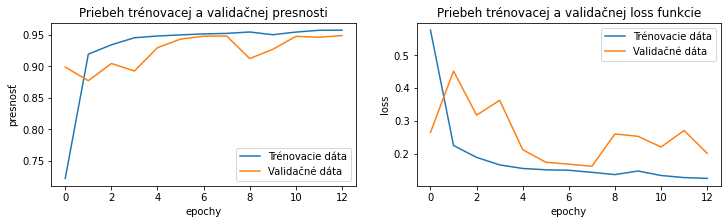

In [ ]:
plt_1 = plt.figure(figsize=(12,3))

acc = history.history['accuracy']
val_acc = history.history[ 'val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) 

plt.subplot(1, 2, 1)
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Priebeh trénovacej a validačnej presnosti')
plt.xlabel('epochy')
plt.ylabel('presnosť')
plt.legend(['Trénovacie dáta', 'Validačné dáta'])

plt.subplot(1, 2, 2)
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Priebeh trénovacej a validačnej loss funkcie')
plt.xlabel('epochy')
plt.ylabel('loss')
plt.legend(['Trénovacie dáta', 'Validačné dáta'])

plt.show()

In [ ]:
score = model.evaluate(test_ds)

44/44 [==============================] - 2s 34ms/step - loss: 0.1912 - accuracy: 0.9412


In [ ]:
test_prediction = model.predict(test_ds)

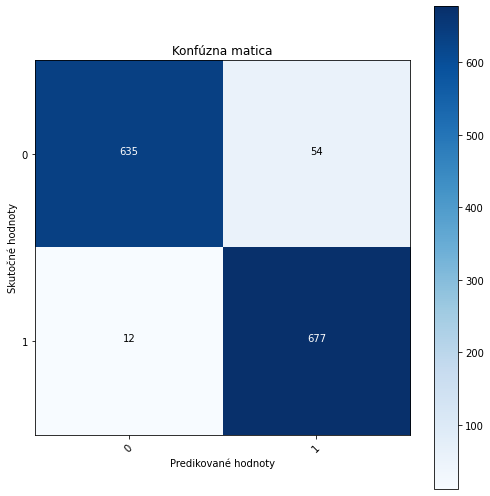

In [ ]:


predictions = np.array([])
labels =  np.array([])
for x, y in test_ds:
  
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis=-1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

cm = tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Konfúzna matica',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    _plt = plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Skutočné hodnoty')
    plt.xlabel('Predikované hodnoty')

# plot the confusion matrix
plot_confusion_matrix(cm, classes = range(2)) 

Found 1378 files belonging to 2 classes.


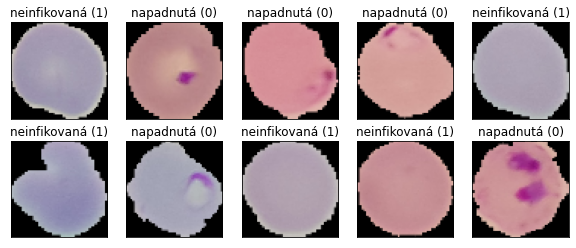

In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  SPLITTED_DATA_DIR + '/test',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')

elem = next(iter(test_ds))

foo = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

plt_2 = plt.figure(figsize=(10,4))

counter = 1
for _ in range(2):
    for _ in range(5):
        ax = plt.subplot(2, 5, counter)
        l = str(np.argmax(elem[1].numpy()[foo[counter-1]]))
        if l == '1':
          l = 'neinfikovaná (1)'
        else:
          l = 'napadnutá (0)'
        plt.title(l)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(elem[0].numpy()[foo[counter-1]].astype(np.uint8))
        counter += 1

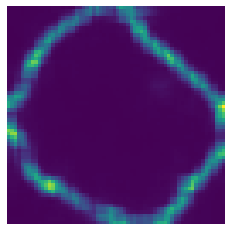

In [ ]:

#  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

image = elem[0].numpy()[6]
# image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
saliency = cv2.saliency.StaticSaliencySpectralResidual_create()
(success, saliencyMap) = saliency.computeSaliency(image)
saliencyMap = (saliencyMap * 255).astype("uint8")
max = np.max(saliencyMap)
min = np.min(saliencyMap)
opencv_mask = (saliencyMap - min) / (max - min)

plt.axis('off')
plt.imshow(opencv_mask)


(64, 64)


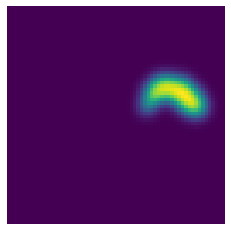

In [ ]:
import matplotlib
from skimage import io, color, filters

# matplotlib.image.imsave('/content/gdrive/MyDrive/diplomovka/stvorka.jpg', np.squeeze(x_test[idx]), cmap='gray')

#TU JU MUSIM RUCNE UPRAVIT

obr = io.imread('/content/gdrive/MyDrive/diplomovka/own_masks/MALARIA/{}.jpg'.format(6))

obr = color.rgb2gray(obr)

sigma = 2.0

# apply Gaussian blur, creating a new image
blurred = filters.gaussian(
    obr, sigma=(sigma, sigma), truncate=3.5, multichannel=True)

print(blurred.shape)
plt.axis('off')
plt.imshow(blurred)

In [ ]:
for idx in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    img=elem[0].numpy()[idx]
    foo = np.expand_dims(img, axis=0)
    label=elem[1].numpy()[idx]
    bar = label.reshape((1,2))
    print(idx)
    print(bar)    
    y_tensor = tf.convert_to_tensor(bar, dtype=tf.float32) 
    model.evaluate(foo , y_tensor)[0]

In [ ]:
class FeatureMapsFusion():
    def __init__(self, input_image=None, label=None, trained_model=None, weight_option=None, lfd_type_2=True):
        """Creates final fused image
        Aggregation function: - expected values = ['entropy', 'loss_function_deviation', 'rectified_loss_function_deviation'].
        """
        self.input_image=input_image
        self.label=label
        self.trained_model=trained_model
        self.aggregation_function=None
        self.weight_option=weight_option
        self.measure=None
        self.lfd_type_2=lfd_type_2

        self.loss_to_compare = trained_model.evaluate(input_image, label)[0]
        self.input_shape = (input_image.shape[1], input_image.shape[2])

        self.feature_maps = []
        self.feature_maps_dict = {}
        self.weights={}

        if not weight_option in ['entropy', 'loss_function_deviation']:
            raise ValueError('Not appropriate aggregation function name!')

        self._get_feature_maps_and_weights()
        self._normalize_weights()
        self._sort_weights_and_feature_maps()
        self._normalize_feature_maps()

    def _get_feature_maps_and_weights(self):     

        if self.weight_option == 'entropy':
            print('using entropy')
            layer_outputs = [layer.output for layer in self.trained_model.layers if 'conv2d' in layer.name]
            feature_map_model = tf.keras.models.Model(inputs=self.trained_model.input, outputs=layer_outputs)

            feature_maps = feature_map_model.predict(self.input_image) 

            for img_stack in feature_maps:
                foo = np.squeeze(img_stack, axis=0)
                foo = np.transpose(foo, axes=[2,0,1])
                foo = list(foo)

                ratio = self.input_shape[0] // foo[0].shape[0] #just one axis

                feature_maps_length = len(self.feature_maps)

                #resize feature map if is needed
                for idx, img in enumerate(foo):
                    if not ratio == 1:                 
                             
                        img = np.repeat(img, ratio, axis=0)
                        img = np.repeat(img, ratio, axis=1)
                        img = transform.resize(img, self.input_shape, anti_aliasing=False, order=2)
                    self.feature_maps.append(img)

                    #entropy calculation
                    self.weights[idx + feature_maps_length] = measure.shannon_entropy(img)
              
        else:            
            print('using loss function deviation')
            for idx, layer in enumerate(self.trained_model.layers):
                if 'conv2d' in layer.name:
                    
                    #splitting model
                    head_model_input = keras.Input(self.trained_model.layers[0].input_shape[1:])
                    head_model = head_model_input 
                    for _layer in self.trained_model.layers[0:idx+1]:
                        head_model = _layer(head_model)
                    head_model = keras.Model(inputs=head_model_input, outputs=head_model)
                    head_model.compile(loss=self.trained_model.loss, optimizer=self.trained_model.optimizer,metrics=self.trained_model.metrics)

                    tail_model_input = keras.Input(self.trained_model.layers[idx+1].input_shape[1:])
                    tail_model = tail_model_input
                    for _layer in self.trained_model.layers[idx+1:]:
                        tail_model = _layer(tail_model)
                    tail_model = keras.Model(inputs=tail_model_input, outputs=tail_model)
                    tail_model.compile(loss=self.trained_model.loss, optimizer=self.trained_model.optimizer.get_config()['name'],metrics=[self.trained_model.metrics[1].get_config()['name']])

                    input_data = self.input_image

                    conv_results = head_model.predict(input_data)
                    conv_results = np.squeeze(conv_results, axis=0)
                    conv_results = np.transpose(conv_results, axes=[2,0,1])
                    conv_results = list(conv_results)

                    dummy_copy = conv_results.copy()

                    conv_results_length = len(conv_results)    
                    ratio = self.input_shape[0] // conv_results[0].shape[0]                     

                    for _index in range(0, conv_results_length):
                        if self.lfd_type_2:         
                            conv_results_copy = np.zeros((conv_results_length, *dummy_copy[0].shape), dtype=np.float32)
                            conv_results_copy[_index] = conv_results[_index].copy()
                            conv_results_copy = np.transpose(conv_results_copy, axes=[1,2,0])
                            conv_results_copy = np.expand_dims(conv_results_copy, axis=0)  
                        else:
                            conv_results_copy = dummy_copy.copy()
                            conv_results_copy.pop(_index)
                            conv_results_copy.insert(_index, np.zeros(dummy_copy[0].shape, dtype=np.float32))
                            conv_results_copy = np.array(conv_results_copy)
                            conv_results_copy = np.transpose(conv_results_copy, axes=[1,2,0])
                            conv_results_copy = np.expand_dims(conv_results_copy, axis=0)    
                                                  
                        evaluation = tail_model.evaluate(conv_results_copy, self.label)                       

                        if self.weight_option == 'loss_function_deviation':
                            self.weights[_index+len(self.feature_maps)] = evaluation[0] - self.loss_to_compar

                        #resize
                        if not ratio == 1:
                            img = conv_results[_index].copy()
                            img = np.repeat(img, ratio, axis=0)
                            img = np.repeat(img, ratio, axis=1)
                            img = transform.resize(img, self.input_shape, anti_aliasing=False, order=2)
                            conv_results[_index] = img  
          
                    self.feature_maps.extend(conv_results)

        self.feature_maps_dict = dict(zip(range(len(self.feature_maps)), self.feature_maps)) 

    def _sort_weights_and_feature_maps(self):
        print('feature maps and weights sorting')
        my_dict = dict(sorted(self.weights.items(), reverse=True, key=lambda item: item[1]))

        ordered_images = []
        ordered_images_dict = {}

        for k,v in my_dict.items():
            ordered_images.append(self.feature_maps_dict[k])  
            ordered_images_dict[k] = self.feature_maps_dict[k]

        self.feature_maps = ordered_images
        self.feature_maps_dict = ordered_images_dict
        self.weights = my_dict

    def _normalize_weights(self):
        print('weights normalization')
        all_values = list(self.weights.values())
        max_value = np.max(np.array(all_values))
        min_value = np.min(np.array(all_values))

        for k,v in self.weights.items():
            foo = self.weights[k]
            foo = (foo - min_value) / (max_value - min_value)
            if not self.lfd_type_2:
                self.weights[k] = foo      
            else:
                self.weights[k] = 1.0 - foo

    def _normalize_feature_maps(self):
        print('feature maps normalization')
        max = 0
        min = np.inf
        for value in self.feature_maps:
            if np.max(value) > max:
                max = np.max(value)
            if np.min(value) < min:
                min = np.min(value)
        self.feature_maps = np.array([(value - min) / (max - min) for value in self.feature_maps])

        new_dict = {}
        for key, value in self.feature_maps_dict.items():
            new_dict[key] = (value - min) / (max - min)

        self.feature_maps_dict = new_dict        

    def additive_measure(self, data):
        return sum(data)

    def average_measure(self, data):
        return sum(data)/len(data)

    def possibility_measure(self, data):
        return np.amax(data, axis=0)    

    def distorted_measure(self, data):
        return sum(data) ** 2

    def choquet_integral(self):
        
        summary = np.zeros(self.input_shape)

        for k in range(0, len(self.feature_maps) - 1):
            summary = summary + (self.weights[k] - self.weights[k+1] ) * self.measure(self.feature_maps[:k+1])

        summary = summary + self.weights[len(self.weights)-1] * self.measure(self.feature_maps)       

        return summary 

    def own_integral(self):
        
        summary = np.zeros(self.input_shape)

        for k in range(0, len(self.feature_maps)):
            summary = summary + self.weights[k] * self.measure(self.feature_maps[:k+1])
 
        return summary 

    def sugeno_integral(self):
        
        weights = list(self.weights.values())
        feature_maps = list(self.feature_maps.copy())

        #because sugeno needs accendent order
        weights.reverse()
        feature_maps.reverse()
        feature_maps = np.array(feature_maps)

        summary = np.zeros(self.input_shape)

        if self.measure.__name__  in ['additive_measure', 'possibility_measure','distorted_measure']:
            for k in range(0, len(weights)):
                summary = np.stack((summary, np.stack((np.full(self.input_shape, weights[k]), self.measure(feature_maps[k:])), axis=0 ).min(0)), axis=0).max(0)
            return summary

        else:
            raise ValueError('Not appropriate measure for Sugeno integral!')
            return summary

    def fuse(self, aggregation_function='choquet', measure=None):
        """Creates final fused image
        Aggregation function: - expected values = ['choquet', 'own', 'sugeno']
        """          

        if not aggregation_function in ['choquet', 'own', 'sugeno']:
            raise ValueError('Not appropriate aggregation function name!')

        if not measure in ['additive', 'average', 'possibility','distorted']:
            raise ValueError('Not appropriate measure name!')

        if measure == 'additive' or measure == 'distorted':
            self.mul_coef = self.feature_maps.sum(0)
        elif measure == 'average':
            self.mul_coef = 1
        elif measure == 'possibility':
            self.mul_coef = self.feature_maps.max(0)
        
        self.feature_maps = self.feature_maps / self.mul_coef 
        
        self.aggregation_function=getattr(self, aggregation_function+'_integral')
        self.measure=getattr(self, measure+'_measure')
        
        agr = self.aggregation_function()

        self.feature_maps = self.feature_maps * self.mul_coef 
        agr = agr * self.mul_coef

        return agr


In [ ]:
entropy_fmfs = {}
lossdev_fmfs = {}

for idx in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    img=elem[0].numpy()[idx]
    foo = np.expand_dims(img, axis=0)
    label=elem[1].numpy()[idx]
    bar = label.reshape((1,2))
    y_tensor = tf.convert_to_tensor(bar, dtype=tf.float32) 

    fmf_en = FeatureMapsFusion(input_image=foo, label=y_tensor, trained_model=model, weight_option='entropy')
    # fmf_ld = FeatureMapsFusion(input_image=foo, label=y_tensor, trained_model=model, weight_option='loss_function_deviation')

    entropy_fmfs[idx] = fmf_en
    # lossdev_fmfs[idx] = fmf_ld

1/1 [==============================] - 0s 40ms/step - loss: 16.1181 - accuracy: 1.0000
using entropy


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:178: UserWarning: Bi-quadratic interpolation behavior has changed due to a bug in the implementation of scikit-image. The new version now serves as a wrapper around SciPy's interpolation functions, which itself is not verified to be a correct implementation. Until skimage's implementation is fixed, we recommend to use bi-linear or bi-cubic interpolation instead.
  preserve_range=preserve_range)


weights normalization
8.046993269686007
0.0
feature maps and weights sorting
feature maps normalization
1/1 [==============================] - 0s 55ms/step - loss: 16.1181 - accuracy: 1.0000
using entropy
weights normalization
8.041195356890189
0.0
feature maps and weights sorting
feature maps normalization
1/1 [==============================] - 0s 38ms/step - loss: 16.1181 - accuracy: 1.0000
using entropy
weights normalization
8.033014834483655
2.8510605096970947
feature maps and weights sorting
feature maps normalization
1/1 [==============================] - 0s 42ms/step - loss: 1.1921e-07 - accuracy: 1.0000
using entropy
weights normalization
8.05419416744231
3.4171492583136738
feature maps and weights sorting
feature maps normalization
1/1 [==============================] - 0s 37ms/step - loss: 16.1181 - accuracy: 1.0000
using entropy
weights normalization
8.081207746482914
0.0
feature maps and weights sorting
feature maps normalization
1/1 [==============================] - 0s 40

In [ ]:

def euklidean_distance(mask_A, mask_B):
    return np.sqrt(np.sum((mask_A - mask_B)**2))

def pearson_corr_coef(mask_A, mask_B): #masky aj histogramy
    A_squared = mask_A **2 
    B_squared = mask_B **2 
    A_B = mask_A * mask_B

    sigma_A_B = np.average(A_B) - np.average(mask_A) * np.average(mask_B)
    sigma_A = np.sqrt(np.average(A_squared)-np.average(mask_A)**2)
    sigma_B = np.sqrt(np.average(B_squared)-np.average(mask_B)**2)

    return sigma_A_B / (sigma_A * sigma_B)

def get_histogram(mask):
    hist, _ = np.histogram(mask, bins=256, range=(0, 1))
    return hist

def auc_roc(mask_A, mask_B):
    '''
    Mask_A by mala byt ground truth.
    sklearn.metrics.cm - Thus in binary classification, the count of true negatives is C_0_0, false negatives is C_1_0,  true positives is C_1_1 and false positives is C_0_1.
    '''
    roc_points = []
    for threshold in range(1, 20):
        threshold = threshold / 20
        thres_A = mask_A > threshold
        thres_B = mask_B > threshold

        cm = metrics.confusion_matrix(thres_A.flatten(),thres_B.flatten())
        tp, fp, tn, fn = cm[1][1], cm[0][1], cm[0][0], cm[1][0]

        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)

        roc_points.append((fpr, tpr))

    roc_points = sorted(roc_points, key=lambda x: x[0])
    roc_points = [(0,0)] + roc_points + [(1,1)]

    auc = 0

    for idx in range(1, len(roc_points)):
        x_diff = roc_points[idx][0] - roc_points[idx-1][0]
        y_diff = roc_points[idx][1] - roc_points[idx-1][1]

        auc = auc + (x_diff * roc_points[idx-1][1]) + ((x_diff * y_diff) / 2)

    return auc

def get_resutls_and_compare_them_all(entropy_fmfs, lossdev_fmfs, measure):

    choq_ent, own_ent, sug_ent, choq_ld, own_ld, sug_ld = {}, {}, {}, {}, {}, {}

    infikovane = [1,2,3,6,9]

    for exp in [choq_ent, own_ent, sug_ent, choq_ld, own_ld, sug_ld]:
        exp['ed'] = []
        exp['en'] = []
        exp['pcch'] = [] 
        exp['pccm'] = []
        exp['auc'] = []

    for key, value in entropy_fmfs.items():
        print("obrazok: {}".format(key))
        for agg, my_dict in [('choquet',choq_ent),('own',own_ent),('sugeno',sug_ent)]:
            result = value.fuse(aggregation_function=agg, measure=measure)           
            max = np.max(result)
            min = np.min(result)
            result = (result - min) / (max - min)

            if key in infikovane:
                #my own mask
                img = io.imread('/content/gdrive/MyDrive/diplomovka/own_masks/MALARIA/{}.jpg'.format(key))
                img = color.rgb2gray(img)
                sigma = 2.0
                blurred = filters.gaussian( img, sigma=(sigma, sigma), truncate=3.5, multichannel=True)
                max = np.max(blurred )
                min = np.min(blurred )
                opencv_mask = (blurred  - min) / (max - min)
            else:
                #opencv2 mask
                # image = np.squeeze(x_test[idx], axis=2)
                image = elem[0].numpy()[key]
                # image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
                saliency = cv2.saliency.StaticSaliencySpectralResidual_create()
                (success, saliencyMap) = saliency.computeSaliency(image)
                saliencyMap = (saliencyMap * 255).astype("uint8")
                max = np.max(saliencyMap)
                min = np.min(saliencyMap)
                opencv_mask = (saliencyMap - min) / (max - min)

            

            my_dict['ed'].append(euklidean_distance(opencv_mask, result))
            my_dict['en'].append(skm.shannon_entropy(result))
            my_dict['pcch'].append(pearson_corr_coef(get_histogram(opencv_mask), get_histogram(result)))
            my_dict['pccm'].append(pearson_corr_coef(opencv_mask, result))
            my_dict['auc'].append(auc_roc(opencv_mask, result))

        # continue
        sec_value = lossdev_fmfs[key]

        for agg, my_dict in [('choquet',choq_ld),('own',own_ld),('sugeno',sug_ld)]:
            result = sec_value.fuse(aggregation_function=agg, measure=measure)
            max = np.max(result)
            min = np.min(result)
            result = (result - min) / (max - min)

            if key in infikovane:
                #my own mask
                img = io.imread('/content/gdrive/MyDrive/diplomovka/own_masks/MALARIA/{}.jpg'.format(key))
                img = color.rgb2gray(img)
                sigma = 2.0
                blurred = filters.gaussian( img, sigma=(sigma, sigma), truncate=3.5, multichannel=True)
                max = np.max(blurred )
                min = np.min(blurred )
                opencv_mask = (blurred  - min) / (max - min)
            else:
                #opencv2 mask
                # image = np.squeeze(x_test[idx], axis=2)
                image = elem[0].numpy()[key]
                # image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
                saliency = cv2.saliency.StaticSaliencySpectralResidual_create()
                (success, saliencyMap) = saliency.computeSaliency(image)
                saliencyMap = (saliencyMap * 255).astype("uint8")
                max = np.max(saliencyMap)
                min = np.min(saliencyMap)
                opencv_mask = (saliencyMap - min) / (max - min)            

            my_dict['ed'].append(euklidean_distance(opencv_mask, result))
            my_dict['en'].append(skm.shannon_entropy(result))
            my_dict['pcch'].append(pearson_corr_coef(get_histogram(opencv_mask), get_histogram(result)))
            my_dict['pccm'].append(pearson_corr_coef(opencv_mask, result))
            my_dict['auc'].append(auc_roc(opencv_mask, result))

    return choq_ent, own_ent, sug_ent, choq_ld, own_ld, sug_ld

choq_ent, own_ent, sug_ent, choq_ld, own_ld, sug_ld = get_resutls_and_compare_them_all(entropy_fmfs, lossdev_fmfs, 'distorted')

    
# for measure in ['additive', 'average', 'possibility','distorted']:
#     get_resutls_and_compare_them_all(entropy_fmfs, lossdev_fmfs, measure):

obrazok: 0
obrazok: 1
obrazok: 2
obrazok: 3
obrazok: 4
obrazok: 5
obrazok: 6
obrazok: 7
obrazok: 8
obrazok: 9


In [ ]:
print(round(sum(choq_ld['ed'])/10, 6)) 
print(round(sum(choq_ld['en'])/10, 6)) 
print(round(sum(choq_ld['pcch'])/10, 6)) 
print(round(sum(choq_ld['pccm'])/10, 6)) 
print(round(sum(choq_ld['auc'])/10, 6)) 

38.137714
11.542665
0.178298
0.047594
0.527363


[]

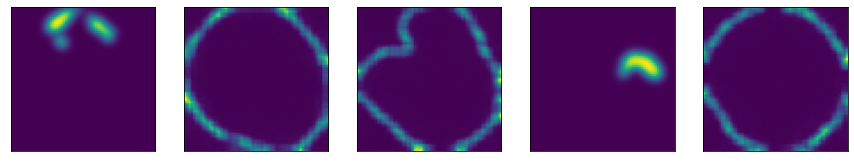

In [ ]:
infikovane = [1,2,3,6,9]

#  [3, 4, 5, 6, 7]
# result = {}
# result[3] = entropy_fmfs[3].fuse(aggregation_function='sugeno', measure='distorted')
# result[4] = entropy_fmfs[4].fuse(aggregation_function='sugeno', measure='distorted')
# result[5] = entropy_fmfs[5].fuse(aggregation_function='sugeno', measure='distorted')
# result[6] = entropy_fmfs[6].fuse(aggregation_function='sugeno', measure='distorted')
# result[7] = entropy_fmfs[7].fuse(aggregation_function='sugeno', measure='distorted')


result = {}
result[3] = elem[0].numpy()[3].astype(np.uint8)
result[4] = elem[0].numpy()[4].astype(np.uint8)
result[5] = elem[0].numpy()[5].astype(np.uint8)
result[6] = elem[0].numpy()[6].astype(np.uint8)
result[7] = elem[0].numpy()[7].astype(np.uint8)

for idx in [3, 4, 5, 6, 7]:

    # image = np.squeeze(x_test[idx], axis=2)
    if idx in infikovane:
        #my own mask
        img = io.imread('/content/gdrive/MyDrive/diplomovka/own_masks/MALARIA/{}.jpg'.format(idx))
        img = color.rgb2gray(img)
        sigma = 2.0
        blurred = filters.gaussian( img, sigma=(sigma, sigma), truncate=3.5, multichannel=True)
        max = np.max(blurred )
        min = np.min(blurred )
        opencv_mask = (blurred  - min) / (max - min)
    else:
        #opencv2 mask
        # image = np.squeeze(x_test[idx], axis=2)
        image = elem[0].numpy()[idx]
        # image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
        saliency = cv2.saliency.StaticSaliencySpectralResidual_create()
        (success, saliencyMap) = saliency.computeSaliency(image)
        saliencyMap = (saliencyMap * 255).astype("uint8")
        max = np.max(saliencyMap)
        min = np.min(saliencyMap)
        opencv_mask = (saliencyMap - min) / (max - min)
    result[idx] = opencv_mask

f, axarr = plt.subplots(1,5, figsize=(15, 3))
axarr[0].imshow(result[3])
# axarr[0].set_title("Opencv maska")
axarr[0].set_xticks([])
axarr[0].set_yticks([])
axarr[1].imshow(result[4])
# axarr[1].set_title("Entropia a  Choquet")
axarr[1].set_xticks([])
axarr[1].set_yticks([])
axarr[2].imshow(result[5])
# axarr[2].set_title("Entropia a vlastná")
axarr[2].set_xticks([])
axarr[2].set_yticks([])
axarr[3].imshow(result[6])
# axarr[3].set_title("Entropia a Sugeno")
axarr[3].set_xticks([])
axarr[3].set_yticks([])
axarr[4].imshow(result[7])
# axarr[4].set_title("Odchýlka lossu a Choquet")
axarr[4].set_xticks([])
axarr[4].set_yticks([])
# axarr[5].imshow(result_5)
# axarr[5].set_title("Odchýlka lossu a vlastná")
# axarr[5].set_xticks([])
# axarr[5].set_yticks([])
# axarr[6].imshow(result_6)
# axarr[6].set_title("Odchýlka lossu a Sugeno")
# axarr[6].set_xticks([])
# axarr[6].set_yticks([])
# print(measure.shannon_entropy(result_6))